In [1]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [2]:
import sys
from func.nets.faster_rcnn import FasterRCNNExtractor

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from chainercv.visualizations import vis_bbox

In [4]:
model = FasterRCNNExtractor(n_fg_class=20, pretrained_model='voc07')

In [5]:
import chainer
import chainer.functions as F
from chainer.iterators import SerialIterator
import pandas as pd
import tables
import numpy as np
import imageio
import os

class GroundingDataPvd(chainer.dataset.DatasetMixin):
    def __init__(self, phrase_pair_file, gtroi_file, root):
        self.pair_data = pd.read_csv(phrase_pair_file)
        self.gtroi_data = pd.read_csv(gtroi_file)
        self.img_root = root
    
    def __len__(self):
        return len(self.pair_data)
    
    def get_phrases(self, i):
        return self.pair_data.iloc[i][['phrase1', 'phrase2']]
    
    def get_gt_roi(self, i):
        img_id, phr_1, phr_2 = self.pair_data.iloc[i][['image', 'phrase1', 'phrase2']]
        rois = self.gtroi_data[self.gtroi_data.image == img_id]
        
        gt_rois = []
        for phr in [phr_1, phr_2]:
            roi = rois[rois.phrase == phr][['ymin', 'xmin', 'ymax', 'xmax']]
            gt_roi_min = roi.min(axis=0)
            gt_roi_max = roi.max(axis=0)
            roi = np.hstack((gt_roi_min[:2], gt_roi_max[-2:]))
            gt_rois.append(roi)
            
        return gt_rois[0], gt_rois[1]
    
    def read_image(self, i):
        img_id = self.pair_data.iloc[i][['image']].values[0]
        img = imageio.imread(os.path.join(self.img_root, str(img_id))+'.jpg')
        return img
    
    def get_example(self, i):
        img = self.read_image(i)
        phr_1, phr_2 = self.get_phrases(i)
        gt_roi_1, gt_roi_2 = self.get_gt_roi(i)
        l = self.pair_data.iloc[i][['ytrue']].values[0]
        
        return img, phr_1, phr_2, gt_roi_1, gt_roi_2, l

split = 'val'
phrase_pair_file = 'data/phrase_pair_%s.csv' % split
gtroi_file = 'data/gt_roi_cord_%s.csv' % split

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from func.datasets.converters import jitter_bbox
# import random

# def jitter_bbox(bbox, im_sizes):
#     '''
#     bbox: numpy array of bounding boxes. bbox[i] is (ymin, xmin, ymax, xmax)
#     im_sizes: array of image sizes. im_size[i] is (channel, height, width)
#     '''
#     if not isinstance(bbox, np.ndarray):
#         bbox = np.asarray(bbox)
    
#     if bbox.dtype != 'float32':
#         bbox = bbox.astype('f')
        
#     _bbox = bbox.copy()
#     y_min = _bbox[:, 0]
#     x_min = _bbox[:, 1]
    
#     w = _bbox[:, -1] - _bbox[:, 1]
#     h = _bbox[:, 2] - _bbox[:, 0]
    
#     n = len(_bbox)
    
#     w_ratio = np.asarray([random.uniform(3/4, 4/3) for _ in range(n)])
#     h_ratio = np.asarray([random.uniform(3/4, 4/3) for _ in range(n)])
#     w *= w_ratio
#     h *= h_ratio
    
#     x_offset = w*np.asarray([random.uniform(-0.2, 0.2) for _ in range(w.size)])
#     y_offset = h*np.asarray([random.uniform(-0.2, 0.2) for _ in range(w.size)])
    
#     x_min += np.fmax(x_offset, 0) # clip at 0
#     y_min += np.fmax(y_offset, 0) # clip at 0
#     y_max = np.clip(y_min + h, 0, im_sizes[:, 1])
#     x_max = np.clip(x_min + w, 0, im_sizes[:, 2])
    
#     j_bbox = np.zeros_like(bbox)
#     j_bbox[:, 0] = y_min
#     j_bbox[:, 1] = x_min
#     j_bbox[:, 2] = y_max
#     j_bbox[:, 3] = x_max
    
#     return j_bbox

In [21]:
def converter(batch, device=None):
    img = [b[0].transpose(2, 0, 1) for b in batch]
    phr_1 = [b[1] for b in batch]
    phr_2 = [b[2] for b in batch]
    gtroi_1 = [b[3] for b in batch]
    gtroi_2 = [b[4] for b in batch]
    l = [b[5] for b in batch]
    
    if chainer.config.train:
        img_size = np.asarray([x.shape for x in img])
        gtroi_1 = jitter_bbox(gtroi_1, img_size, 2/3, 0.4)
        gtroi_2 = jitter_bbox(gtroi_2, img_size)
    
    return img, phr_1, phr_2, gtroi_1, gtroi_2, l

In [19]:
data = GroundingDataPvd(phrase_pair_file, gtroi_file, 'data/flickr30k-images/')

glasses small+child
baby woman


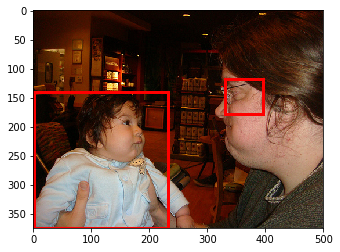

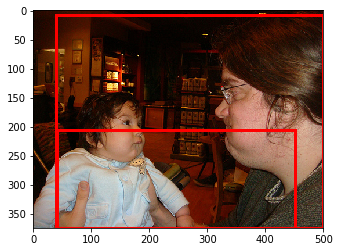

In [34]:
i = np.random.randint(0, len(data)-2)
batch = converter(data[i:i+2])
for i in range(2):
    img = batch[0][i]
    gtroi_1 = batch[3][i]
    gtroi_2 = batch[4][i]
    vis_bbox(img, np.vstack((gtroi_1, gtroi_2)))
    print(batch[1][i], batch[2][i])

In [97]:
itr = SerialIterator(data, 3)
img, phr_1, phr_2, gtroi_1, gtroi_2, l = converter(itr.next())
img_ = [model.prepare(x) for x in img]
scale = [max(im_.shape[1:]) / max(im.shape[1:]) for im, im_ in zip(img, img_)]

y = []

for im, roi1, roi2, s in zip(img_, gtroi_1, gtroi_2, scale):
    roi = np.vstack((roi1, roi2)) * s
    y.append(model.extract(im[None,:], roi, np.zeros((2,)).astype('i')))

y = F.vstack(y)
y = y.reshape(-1, 4096 * 2)

In [ ]:
class iParaphraseNet(chainer.Chain):
    def __init__(self):
        super(iParaphraseNet, self).__init__()
        with self.init_scope():
            base_net = FasterRCNNExtractor(n_fg_class=20, pretrained_model='voc07')
            fusion_net = fusion_net
            classifier = classifier

In [114]:
import chainer.links as L

l1 = L.Linear(None, 3)
l2 = L.Linear(None, 3)
x = np.random.random((3,3)).astype('f')
y = np.random.random((3,3)).astype('f')
# with chainer.using_config('enable_backprop', False):
h = l1(x)
h1 = l2(h)
l = F.sum(F.squared_error(h1, y))
l.backward(0)